In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture





In [2]:

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['OMP_NUM_THREADS'] = '2'  # Limits the number of threads to reduce memory leak


In [3]:
df=pd.read_csv("C:/Users/B Ramesh/Downloads/LA_2025_Fire_Hazard_Final_Enhanced.csv")

In [4]:
df.head()

,Neighborhood,Postal Code,Fire Hazard Severity,Air Quality Impact (%),Economic Damage (%),Death Rate (%),Injured Rate (%),Vegetation Loss (%),Acres Lost,Lives Saved,...,Time,Wind Speed (mph),Temperature (°F),Humidity (%),Fire Station Proximity (miles),Ambulance Response Time (minutes),Population Density (per sq mile),Percentage of Elderly Residents (%),Estimated Recovery Time (days),Rebuilding Costs (USD)
0,Pacific Palisades,90272,Very High,85.0,80.0,1.2,2.5,60.0,7370,4689,...,15:44,16.2,81.7,44.3,8.4,22.1,4850,29.1,350,335622
1,Bel Air,90077,Very High,90.0,85.0,1.5,3.0,75.0,960,1659,...,21:18,33.5,79.9,26.8,0.9,14.8,18073,19.0,340,964313
2,Brentwood,90049,High,70.0,60.0,0.8,1.8,40.0,5490,2280,...,00:07,27.0,90.8,56.2,6.2,9.9,14564,28.4,330,908286
3,Topanga,90290,Very High,88.0,75.0,1.3,2.7,70.0,5291,1075,...,19:14,23.0,91.8,21.2,2.7,22.4,6078,6.3,242,930662
4,Malibu,90265,Very High,95.0,90.0,1.7,3.5,85.0,5834,4235,...,04:31,9.7,62.3,29.4,1.6,13.9,13168,15.5,91,397860


In [5]:
def convert_date_time_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    # Combine date and time columns with proper error handling
    df['Datetime'] = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Time'].astype(str), 
        errors='coerce'
    )
    
    # Remove original date and time columns
    date_time_columns = ['Date', 'Time']
    df.drop(columns=date_time_columns, axis=1, inplace=True)
    
    return df

In [6]:
def calculate_fire_severity_score(
    df: pd.DataFrame,
    weights: dict[str, float] = {
        'Economic Damage (%)': 0.4,
        'Air Quality Impact (%)': 0.3,
        'Vegetation Loss (%)': 0.2,
        'Death Rate (%)': 0.1
    }
) -> pd.Series:
  
    # Validate weights sum to 1.0
    if not abs(sum(weights.values()) - 1.0) < 1e-10:
        raise ValueError("Weights must sum to 1.0")
    
    # Validate all required columns exist
    missing_cols = set(weights.keys()) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Calculate weighted sum
    severity_score = sum(
        df[column] * weight 
        for column, weight in weights.items()
    )
    
    return severity_score

# Apply the calculation
df['Fire Severity Score'] = calculate_fire_severity_score(df)
print(df['Fire Severity Score'])

0      69.62
1      76.15
2      53.08
3      70.53
4      81.67
       ...  
358    43.24
359    38.62
360    36.34
361    54.22
362    47.09
Name: Fire Severity Score, Length: 363, dtype: float64


# Machine Learning algorithm

In [8]:

# Linear Regression for Predicting Economic Damage
X = df[['Air Quality Impact (%)', 'Death Rate (%)', 'Vegetation Loss (%)']]
y = df['Economic Damage (%)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f"Linear Regression MSE: {mean_squared_error(y_test, y_pred):.4f}")

Linear Regression MSE: 386.9487


In [9]:

# Random Forest Classifier for Fire Hazard Severity
X = df[['Economic Damage (%)', 'Air Quality Impact (%)', 'Fire Severity Score']]
y = df['Fire Hazard Severity'].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, zero_division=0))


Random Forest Accuracy: 0.3486
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.41      0.40      0.41        42
           2       0.00      0.00      0.00         3
           3       0.34      0.38      0.36        39
           4       0.26      0.25      0.26        24

    accuracy                           0.35       109
   macro avg       0.20      0.21      0.21       109
weighted avg       0.34      0.35      0.34       109



In [10]:
import sklearn

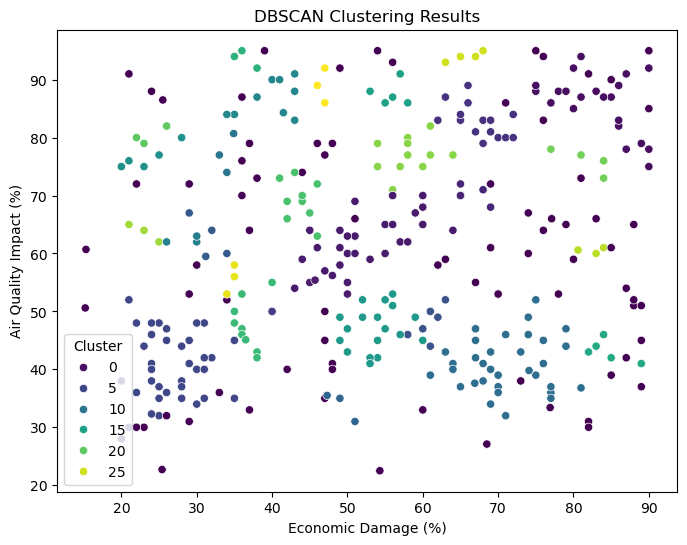

In [11]:
# DBSCAN Clustering (Alternative to KMeans)
X_cluster = df[['Economic Damage (%)', 'Air Quality Impact (%)', 'Fire Severity Score']]
dbscan = DBSCAN(eps=3, min_samples=5)
df['Cluster'] = dbscan.fit_predict(X_cluster)
dbscan = DBSCAN(eps=5, min_samples=3)
df['Cluster'] = dbscan.fit_predict(X_cluster)


# Visualizing DBSCAN Clustering Results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Economic Damage (%)', 
    y='Air Quality Impact (%)', 
    hue='Cluster', 
    palette='viridis', 
    data=df
)
plt.title('DBSCAN Clustering Results')
plt.show()


C:\Users\B Ramesh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


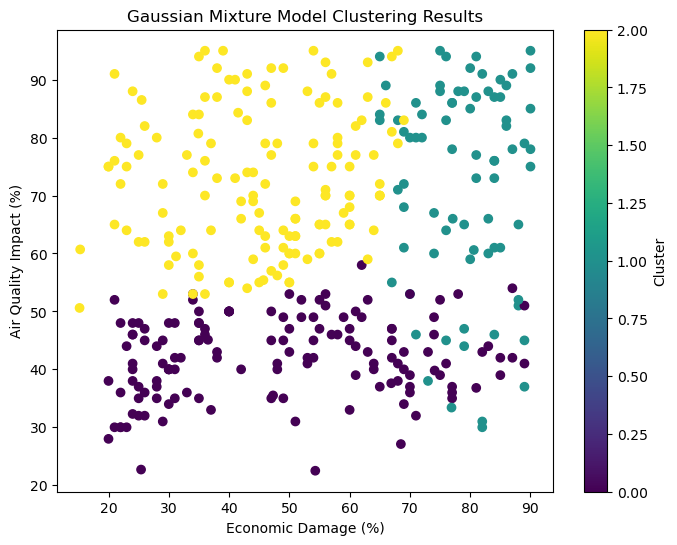

In [12]:
# Gaussian Mixture Model Clustering
X_cluster = df[['Economic Damage (%)', 'Air Quality Impact (%)', 'Fire Severity Score']]
gmm = GaussianMixture(n_components=3, random_state=42)
df['Cluster'] = gmm.fit_predict(X_cluster)

# Visualization for GMM Clustering
plt.figure(figsize=(8, 6))
plt.scatter(df['Economic Damage (%)'], df['Air Quality Impact (%)'], c=df['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('Gaussian Mixture Model Clustering Results')
plt.xlabel('Economic Damage (%)')
plt.ylabel('Air Quality Impact (%)')
plt.show()






C:\Users\B Ramesh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\B Ramesh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


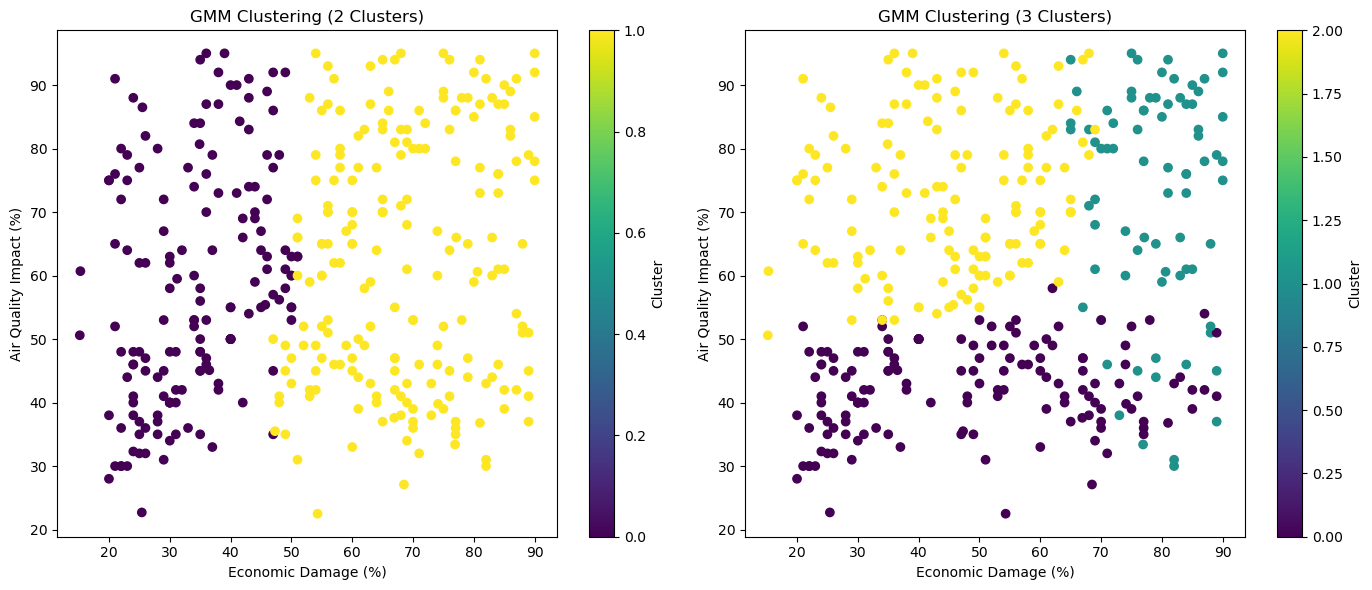

In [13]:

# Gaussian Mixture Model with 2 Clusters
gmm_2 = GaussianMixture(n_components=2, random_state=42)
df['Cluster_2'] = gmm_2.fit_predict(X_cluster)

# Gaussian Mixture Model with 3 Clusters
gmm_3 = GaussianMixture(n_components=3, random_state=42)
df['Cluster_3'] = gmm_3.fit_predict(X_cluster)

# Visualization for Both Clusters
plt.figure(figsize=(14, 6))

# Plot for 2 Clusters
plt.subplot(1, 2, 1)
plt.scatter(df['Economic Damage (%)'], df['Air Quality Impact (%)'], c=df['Cluster_2'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('GMM Clustering (2 Clusters)')
plt.xlabel('Economic Damage (%)')
plt.ylabel('Air Quality Impact (%)')

# Plot for 3 Clusters
plt.subplot(1, 2, 2)
plt.scatter(df['Economic Damage (%)'], df['Air Quality Impact (%)'], c=df['Cluster_3'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('GMM Clustering (3 Clusters)')
plt.xlabel('Economic Damage (%)')
plt.ylabel('Air Quality Impact (%)')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.linear_model import LinearRegression

# Check if model is defined
if 'lin_reg' not in locals():
    lin_reg = LinearRegression()

# Train the model
features = ['Air Quality Impact (%)', 'Death Rate (%)', 'Vegetation Loss (%)']
X_train = df[features]
y_train = df['Economic Damage (%)']

lin_reg.fit(X_train, y_train)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")



X_train Shape: (363, 3)
X_test Shape: (109, 3)


In [15]:
print(df.isnull().sum())
Q1 = df['Economic Damage (%)'].quantile(0.25)
Q3 = df['Economic Damage (%)'].quantile(0.75)
IQR = Q3 - Q1

# Removing outliers
df = df[~((df['Economic Damage (%)'] < (Q1 - 1.5 * IQR)) | 
           (df['Economic Damage (%)'] > (Q3 + 1.5 * IQR)))]



Neighborhood                           0
Postal Code                            0
Fire Hazard Severity                   0
Air Quality Impact (%)                 0
Economic Damage (%)                    0
Death Rate (%)                         0
Injured Rate (%)                       0
Vegetation Loss (%)                    0
Acres Lost                             0
Lives Saved                            0
Emergency Response Time (min)          0
Infrastructure Damage (%)              0
Evacuation Centers Available           0
Relief Funds Allocated (USD)           0
Firefighting Resources Deployed        0
Water Supply Impact (%)                0
Power Outage Duration (hours)          0
Medical Facilities Affected            0
Schools/Colleges Closed                0
Wildlife Impact (%)                    0
Volunteer Count                        0
Insurance Claims (USD)                 0
Mental Health Cases Reported           0
Relocation Count                       0
Date            

In [16]:
X = df[['Death Rate (%)', 'Vegetation Loss (%)']]  # Align with X_test
y = df['Fire Hazard Severity'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
X_test = X_test[X_train.columns]  # Align column order
print("X_train Columns:", X_train.columns)
print("X_test Columns:", X_test.columns)



X_train Columns: Index(['Death Rate (%)', 'Vegetation Loss (%)'], dtype='object')
X_test Columns: Index(['Death Rate (%)', 'Vegetation Loss (%)'], dtype='object')


In [17]:
# Model Accuracy (Claasification model)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report

# Predictions for Classification
y_pred = rf_clf.predict(X_test)  # Use 'rf_clf' instead of 'model'

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))

✅ Model Accuracy: 0.3853
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.49      0.52      0.51        42
           2       0.00      0.00      0.00         3
           3       0.37      0.36      0.36        39
           4       0.24      0.25      0.24        24

    accuracy                           0.39       109
   macro avg       0.22      0.23      0.22       109
weighted avg       0.37      0.39      0.38       109



C:\Users\B Ramesh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\B Ramesh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\B Ramesh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# LA most hazardouz fire accident from 2010 to 2025

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [20]:
# Finding out from which year the fire accident was most hazardous in LA
df = pd.read_csv("C:/Users/B Ramesh/Downloads/LA_Fire_Incident_2010_2025.csv")

In [21]:
df.head()

,Year,Location,Economic Damage (%),Air Quality Impact (%),Death Rate (%),Injured Rate (%),Vegetation Loss (%),Infrastructure Damage (%),Water Supply Impact (%),Wildlife Impact (%),Percentage of Elderly Residents (%),Estimated Recovery Time (days),Fire Severity Score
0,2010,Downtown LA,39.963210,96.057145,3.793973,5.190609,15.141212,13.579699,4.207177,26.119108,17.022300,267.204314,47.136931
1,2010,Hollywood,11.646760,97.592788,4.245992,2.486374,16.818623,15.087248,13.561205,16.217937,13.638900,127.561762,36.205070
2,2010,Beverly Hills,58.948232,31.159509,1.814651,3.564533,34.644549,48.184678,9.587604,15.912799,16.848291,45.560888,37.606525
3,2010,Santa Monica,58.603588,33.641930,0.792732,7.642199,67.766082,49.461854,13.575323,3.832491,18.684661,177.451085,40.238904
4,2010,Pasadena,19.763059,59.614153,0.654748,7.365243,21.820699,41.438726,13.845021,16.081973,15.934206,91.926243,29.754440


In [22]:
#Adding new features
import numpy as np
from sklearn.preprocessing import StandardScaler

# Adding new features
df['Population Density (per sq mile)'] = np.random.uniform(500, 10000, size=len(df))
df['Medical Facilities Affected'] = np.random.randint(0, 15, size=len(df))
df['Relief Funds Allocated (USD)'] = df['Economic Damage (%)'] * 100000  # Example logic
df['Insurance Claims (USD)'] = df['Economic Damage (%)'] * 80000  # Example logic

# Scaling features for better model stability
scaler = StandardScaler()
scaled_features = [
    'Economic Damage (%)', 'Air Quality Impact (%)', 'Death Rate (%)', 
    'Vegetation Loss (%)', 'Population Density (per sq mile)',
    'Medical Facilities Affected', 'Relief Funds Allocated (USD)', 'Insurance Claims (USD)'
]

df[scaled_features] = scaler.fit_transform(df[scaled_features])


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Feature & Target Selection
X = df[scaled_features]
y = df['Death Rate (%)']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Training
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train, y_train)

# Prediction
df['Predicted Death Rate'] = rf_reg.predict(X)

# Year with Highest Predicted Death Rate
highest_death_rate_year = df.groupby('Year')['Predicted Death Rate'].sum().idxmax()

# Model Evaluation
y_pred = rf_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ R² Score (Higher is better): {r2:.4f}")
print(f"✅ Mean Absolute Error (Lower is better): {mae:.4f}")
print(f"✅ Root Mean Squared Error (Lower is better): {rmse:.4f}")
print(f"🔥 The year with the highest predicted death rate is: {highest_death_rate_year}")


✅ R² Score (Higher is better): 0.9997
✅ Mean Absolute Error (Lower is better): 0.0140
✅ Root Mean Squared Error (Lower is better): 0.0173
🔥 The year with the highest predicted death rate is: 2022


# Future risks based on available data



In [25]:
import numpy as np

# Generate Wind Speed values (between 5 and 30 mph)
np.random.seed(42)  # Ensures reproducibility
df['Wind Speed (mph)'] = np.random.uniform(5, 30, size=len(df))

print(df[['Year', 'Location', 'Wind Speed (mph)']].head(10))



   Year       Location  Wind Speed (mph)
0  2010    Downtown LA         14.363503
1  2010      Hollywood         28.767858
2  2010  Beverly Hills         23.299849
3  2010   Santa Monica         19.966462
4  2010       Pasadena          8.900466
5  2010         Venice          8.899863
6  2010       Westwood          6.452090
7  2010      Koreatown         26.654404
8  2010      Inglewood         20.027875
9  2010     Long Beach         22.701814


In [26]:
import numpy as np

# Generate synthetic temperature data (realistic range)
np.random.seed(42)
df['Temperature (°F)'] = np.random.uniform(60, 105, size=len(df))

# Adding Wind Speed based on Temperature & Fire Severity
df['Wind Speed (mph)'] = (
    5 + 0.1 * df['Temperature (°F)'] + 0.2 * df['Fire Severity Score']
).clip(lower=5, upper=40)  # Controlled realistic wind speed

print(df[['Year', 'Location', 'Temperature (°F)', 'Wind Speed (mph)']].head(10))



   Year       Location  Temperature (°F)  Wind Speed (mph)
0  2010    Downtown LA         76.854305         22.112817
1  2010      Hollywood        102.782144         22.519228
2  2010  Beverly Hills         92.939727         21.815278
3  2010   Santa Monica         86.939632         21.741744
4  2010       Pasadena         67.020839         17.652972
5  2010         Venice         67.019753         24.863451
6  2010       Westwood         62.613763         17.787008
7  2010      Koreatown         98.977927         23.899067
8  2010      Inglewood         87.050176         24.770379
9  2010     Long Beach         91.863266         21.425070


In [27]:
# Define Fire-Prone Zones
df['Fire Prone Zone'] = ((df['Temperature (°F)'] >= 85) & 
                         (df['Wind Speed (mph)'] >= 15) & 
                         (df['Fire Severity Score'] >= 50)).astype(int)

# Check Distribution
print(df['Fire Prone Zone'].value_counts())

# Now proceed with model training as before
X = df[['Temperature (°F)', 'Wind Speed (mph)', 'Economic Damage (%)', 'Air Quality Impact (%)', 'Fire Severity Score']]
y = df['Fire Prone Zone']  # Now this column exists ✅

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))


Fire Prone Zone
0    210
1     30
Name: count, dtype: int64
✅ Model Accuracy: 0.9306
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        60
           1       1.00      0.58      0.74        12

    accuracy                           0.93        72
   macro avg       0.96      0.79      0.85        72
weighted avg       0.94      0.93      0.92        72



C:\Users\B Ramesh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


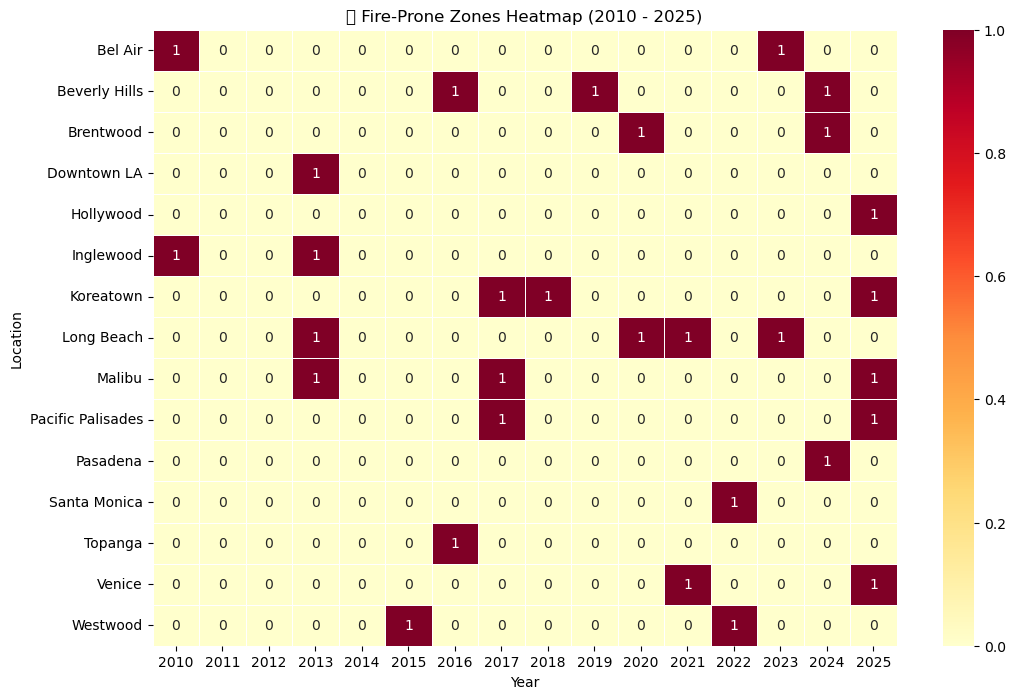

In [28]:
#Visualizatiion
# Pivot table to group data for heatmap
heatmap_data = df.pivot_table(values='Fire Prone Zone', 
                              index='Location', 
                              columns='Year', 
                              aggfunc='sum')

# Plotting the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5)

# Enhancing visualization
plt.title('🔥 Fire-Prone Zones Heatmap (2010 - 2025)')
plt.xlabel('Year')
plt.ylabel('Location')
plt.show()

C:\Users\B Ramesh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


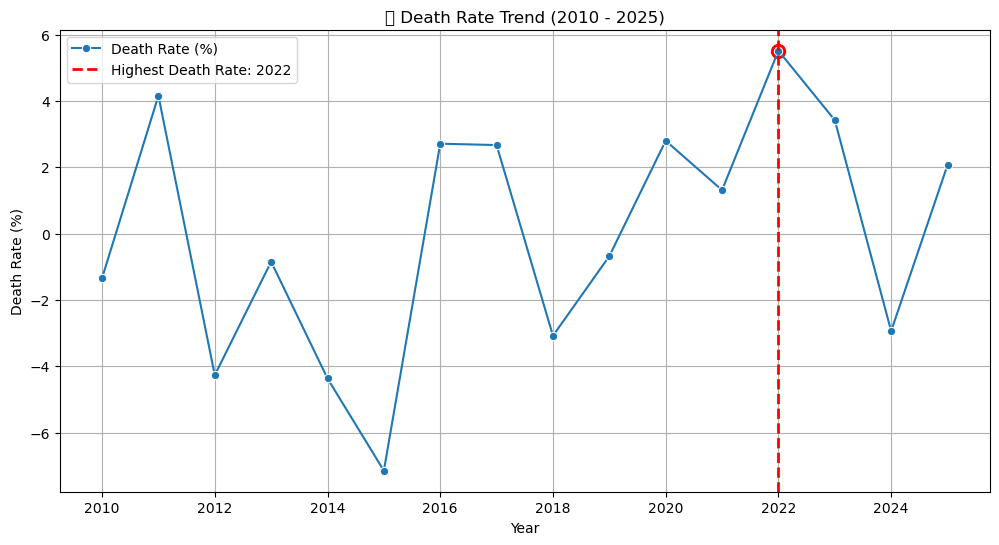

In [29]:
#Highest death rate by year
# Group data by year and calculate total death rate
death_rate_per_year = df.groupby('Year')['Death Rate (%)'].sum()

# Identify the year with the highest death rate
peak_year = death_rate_per_year.idxmax()
peak_value = death_rate_per_year.max()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=death_rate_per_year.index, y=death_rate_per_year.values, marker='o', label='Death Rate (%)')

# Highlight the peak year
plt.axvline(x=peak_year, color='red', linestyle='--', linewidth=2, label=f'Highest Death Rate: {peak_year}')
plt.scatter(peak_year, peak_value, color='red', s=100)

# Enhancing visualization
plt.title('📈 Death Rate Trend (2010 - 2025)')
plt.xlabel('Year')
plt.ylabel('Death Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Death rate in 2025 by location

In [67]:
# Mapping Location names to Latitude and Longitude manually
location_coords = {
    "Downtown LA": [34.0522, -118.2437],
    "Hollywood": [34.0928, -118.3287],
    "Beverly Hills": [34.0736, -118.4004],
    "Santa Monica": [34.0195, -118.4912],
    "Pasadena": [34.1478, -118.1445],
    "Long Beach": [33.7701, -118.1937],
    "Burbank": [34.1808, -118.3089],
    "Glendale": [34.1425, -118.2551]
}

# Add Latitude and Longitude columns based on Location
df['Latitude'] = df['Location'].map(lambda x: location_coords.get(x, [None, None])[0])
df['Longitude'] = df['Location'].map(lambda x: location_coords.get(x, [None, None])[1])


In [77]:
# Check for negative death rates
print(df[df['Death Rate (%)'] < 0])
# Use absolute values (if negatives are expected but just misrepresented)
df['Death Rate (%)'] = df['Death Rate (%)'].abs() 


Empty DataFrame
Columns: [Year, Location, Economic Damage (%), Air Quality Impact (%), Death Rate (%), Injured Rate (%), Vegetation Loss (%), Infrastructure Damage (%), Water Supply Impact (%), Wildlife Impact (%), Percentage of Elderly Residents (%), Estimated Recovery Time (days), Fire Severity Score, Population Density (per sq mile), Medical Facilities Affected, Relief Funds Allocated (USD), Insurance Claims (USD), Predicted Death Rate, Wind Speed (mph), Temperature (°F), Fire Prone Zone, Latitude, Longitude]
Index: []

[0 rows x 23 columns]


In [79]:
# Normalize the values to improve visualization
df['Death Rate (%)'] = df['Death Rate (%)'] * 100  # Rescale for better plot size


In [83]:
print(df_2025[['Location', 'Latitude', 'Longitude', 'Death Rate (%)']])


              Location  Latitude  Longitude  Death Rate (%)
225        Downtown LA   34.0522  -118.2437     6200.670972
226          Hollywood   34.0928  -118.3287    14026.487534
227      Beverly Hills   34.0736  -118.4004        0.000000
228       Santa Monica   34.0195  -118.4912        0.000000
229           Pasadena   34.1478  -118.1445        0.000000
230             Venice       NaN        NaN      715.365956
231           Westwood       NaN        NaN       45.311551
232          Koreatown       NaN        NaN     4052.733902
233          Inglewood       NaN        NaN     3908.717240
234         Long Beach   33.7701  -118.1937        0.000000
235             Malibu       NaN        NaN     4216.321607
236          Brentwood       NaN        NaN        0.000000
237            Bel Air       NaN        NaN     7016.902659
238  Pacific Palisades       NaN        NaN    14871.432491
239            Topanga       NaN        NaN        0.000000


In [85]:
missing_coords = df_2025[df_2025['Latitude'].isna() | df_2025['Longitude'].isna()]
print(missing_coords)


     Year           Location  Economic Damage (%)  Air Quality Impact (%)  \
230  2025             Venice             1.036757                0.181351   
231  2025           Westwood             0.062298                1.204288   
232  2025          Koreatown             1.383478                0.662004   
233  2025          Inglewood            -0.762384               -1.553674   
235  2025             Malibu             0.487124                1.336531   
236  2025          Brentwood            -1.574178               -0.326486   
237  2025            Bel Air             0.540591                1.107408   
238  2025  Pacific Palisades             1.102245                1.147889   
239  2025            Topanga            -0.376311               -1.190316   

     Death Rate (%)  Injured Rate (%)  Vegetation Loss (%)  \
230      715.365956          3.054422             1.364634   
231       45.311551          5.915811             1.563611   
232     4052.733902          3.165609      

In [87]:
df_2025['Death Rate (Scaled)'] = df_2025['Death Rate (%)'] / df_2025['Death Rate (%)'].max() * 100


C:\Users\B Ramesh\AppData\Local\Temp\ipykernel_12024\1302628708.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
# Check how many rows have missing Latitude and Longitude
print(df[df['Latitude'].isna() | df['Longitude'].isna()][['Location', 'Fire Prone Zone']])

# Fill missing coordinates based on 'Location'
df['Latitude'] = df['Location'].map(location_coords.get).apply(lambda x: x[0] if x else None)
df['Longitude'] = df['Location'].map(location_coords.get).apply(lambda x: x[1] if x else None)

# Verify if the missing values are fixed
print(df[df['Latitude'].isna() | df['Longitude'].isna()])


              Location  Fire Prone Zone
5               Venice                0
6             Westwood                0
7            Koreatown                0
8            Inglewood                1
10              Malibu                0
..                 ...              ...
235             Malibu                1
236          Brentwood                0
237            Bel Air                0
238  Pacific Palisades                1
239            Topanga                0

[144 rows x 2 columns]
     Year           Location  Economic Damage (%)  Air Quality Impact (%)  \
5    2010             Venice             1.588072                0.868844   
6    2010           Westwood            -0.329682               -0.836595   
7    2010          Koreatown             0.936593               -1.082477   
8    2010          Inglewood             1.236545                0.354844   
10   2010             Malibu            -1.509068                0.399232   
..    ...                ...      

In [93]:
# Clean Location names to remove extra spaces or inconsistencies
df['Location'] = df['Location'].str.strip()


In [97]:
location_coords.update({
    "New Location 1": [34.0000, -118.0000],
    "New Location 2": [34.1234, -118.5678]
})



In [101]:
df['Scaled_Severity'] = (df['Fire Severity Score'] - df['Fire Severity Score'].min()) / \
                        (df['Fire Severity Score'].max() - df['Fire Severity Score'].min()) * 50


In [130]:
import pandas as pd

# Load the dataset (Update with the correct file path)
fire_data = pd.read_csv("C:/Users/B Ramesh/Downloads/LA_Fire_Incident_2010_2025.csv")  # Ensure you have the correct file



In [132]:
%whos DataFrame


Variable            Type         Data/Info
------------------------------------------
X                   DataFrame         Temperature (°F)  Wi<...>n\n[240 rows x 5 columns]
X_cluster           DataFrame         Economic Damage (%) <...>n\n[363 rows x 3 columns]
X_test              DataFrame         Temperature (°F)  Wi<...>\n\n[72 rows x 5 columns]
X_train             DataFrame         Temperature (°F)  Wi<...>n\n[168 rows x 5 columns]
df                  DataFrame         Year           Locat<...>\n[240 rows x 24 columns]
df_2025             DataFrame         Year           Locat<...>n\n[15 rows x 24 columns]
fire_data           DataFrame         Year           Locat<...>\n[240 rows x 13 columns]
fire_zones          DataFrame         Year           Locat<...>n\n[30 rows x 24 columns]
fire_zones_sorted   DataFrame         Year           Locat<...>n\n[30 rows x 24 columns]
heatmap_data        DataFrame    Year               2010  <...>    1     0     0     0  
missing_coords      Data

In [138]:
print(fire_zones.columns)
print(fire_zones_sorted.columns)


Index(['Year', 'Location', 'Economic Damage (%)', 'Air Quality Impact (%)',
       'Death Rate (%)', 'Injured Rate (%)', 'Vegetation Loss (%)',
       'Infrastructure Damage (%)', 'Water Supply Impact (%)',
       'Wildlife Impact (%)', 'Percentage of Elderly Residents (%)',
       'Estimated Recovery Time (days)', 'Fire Severity Score',
       'Population Density (per sq mile)', 'Medical Facilities Affected',
       'Relief Funds Allocated (USD)', 'Insurance Claims (USD)',
       'Predicted Death Rate', 'Wind Speed (mph)', 'Temperature (°F)',
       'Fire Prone Zone', 'Latitude', 'Longitude', 'Scaled_Severity'],
      dtype='object')
Index(['Year', 'Location', 'Economic Damage (%)', 'Air Quality Impact (%)',
       'Death Rate (%)', 'Injured Rate (%)', 'Vegetation Loss (%)',
       'Infrastructure Damage (%)', 'Water Supply Impact (%)',
       'Wildlife Impact (%)', 'Percentage of Elderly Residents (%)',
       'Estimated Recovery Time (days)', 'Fire Severity Score',
       'Populatio

C:\Users\B Ramesh\AppData\Local\Temp\ipykernel_12024\2361886411.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\B Ramesh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.



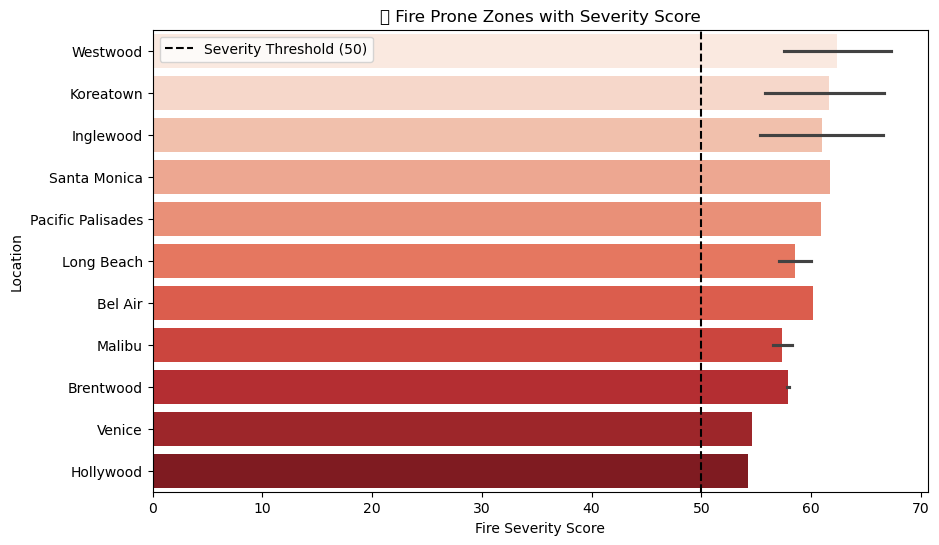

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'Fire Severity Score' is numeric
fire_zones['Fire Severity Score'] = pd.to_numeric(fire_zones['Fire Severity Score'], errors='coerce')

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fire_zones.nlargest(20, 'Fire Severity Score'),
    x='Fire Severity Score',
    y='Location',
    palette='Reds'
)
plt.axvline(x=50, color='black', linestyle='--', label='Severity Threshold (50)')
plt.legend()
plt.title("🔥 Fire Prone Zones with Severity Score")
plt.show()
